## CNVs in validation set

In [1]:
from tidyverse.dummy import *
import scanpy as sc
from sctools import pipeline, adata_merge
# import sys
# sys.path.append('/users/mstrasse/CRUK-code')
from rnaseqtools import biomart_mapping
# external library
sys.path.append('/users/mstrasse/McGill_analysis/instance-1-backup/infercnvpy/src/')
import infercnvpy as cnv
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

Importing tidyverse


In [2]:
import sys
sys.path.append('..')
from util import load_original_data, load_validation_data
from cnv import CNV_prep

In [3]:
reference_field = 'cnv_ref'
reference_cats = ['reference_NE', 'reference_NS']

# Calculating CNVs
## Normal cells

In [4]:
adata_normal = load_original_data()

In [6]:
adata_normal= adata_normal[
    np.logical_and(
        adata_normal.obs.celltype_split.isin(["Columnar Epithelium", "Squamous Epithelium"]),
        adata_normal.obs.diagnosis.isin(["NE","NS"])
    )].copy()

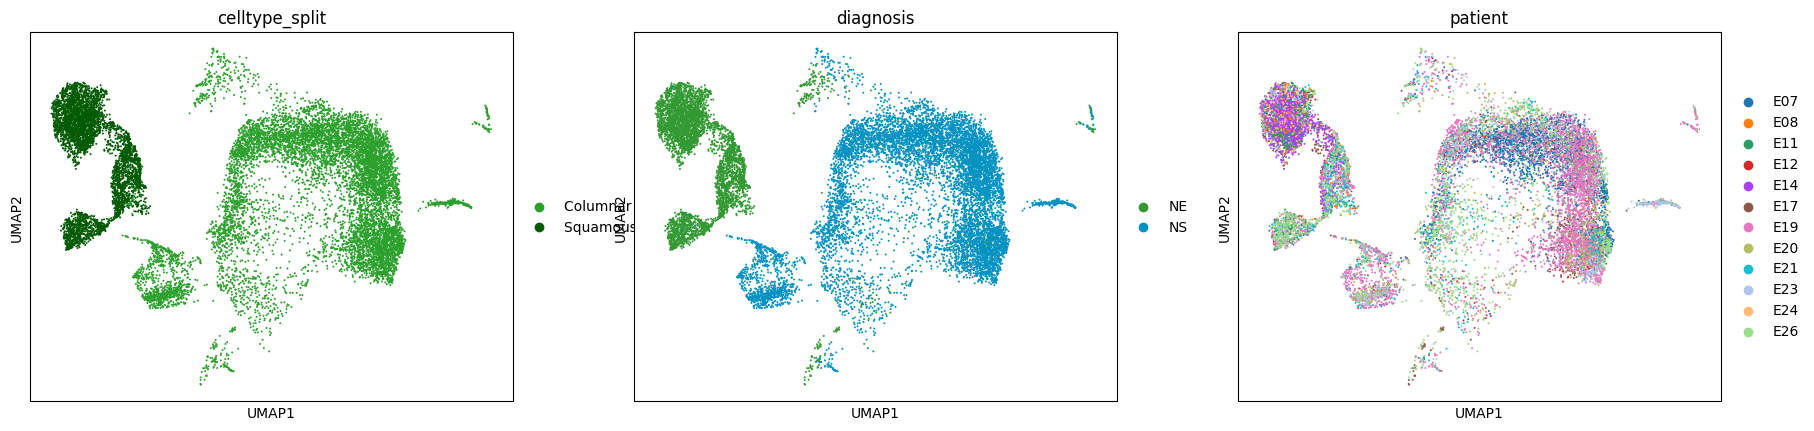

In [7]:
sc.pl.umap(adata_normal, color=['celltype_split', 'diagnosis', 'patient'])

In [8]:
import gc
gc.collect()

15712

## Tumor cells

In [9]:
adata_validation = load_validation_data()

In [10]:
adata_validation._inplace_subset_obs(adata_validation.obs.celltype_split.isin(["Columnar Epithelium", "Squamous Epithelium"]))

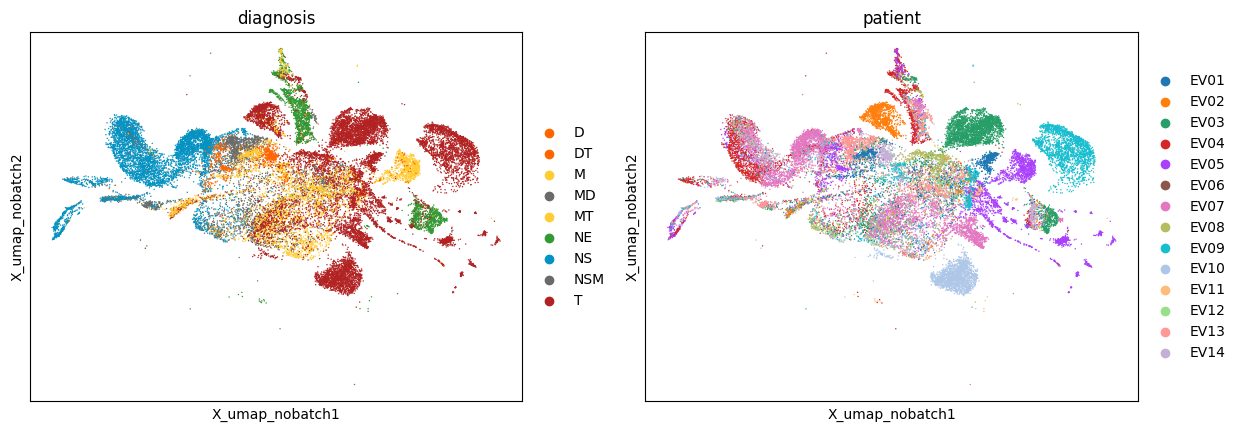

In [11]:
sc.pl.embedding(adata_validation, basis='X_umap_nobatch', color=['diagnosis', 'patient'])

## Prep

need to filter out some duplicate samples already in NE

In [12]:
ref_samples = set(adata_normal.obs.samplename)
query_samples = set(adata_validation.obs.samplename)

In [13]:
adata_validation._inplace_subset_obs(
    adata_validation.obs.samplename.isin(
       query_samples - ref_samples
))

mneed to take out any samples already in the reference set!

In [14]:
assert set(adata_normal.obs.samplename) & set(adata_validation.obs.samplename) == set(), "no overlap allowed"

In [15]:
set(adata_validation.var.index) ^ set(adata_normal.var.index) 

set()

In [16]:
assert np.all(adata_validation.var.index == adata_normal.var.index) 

In [17]:
adata = adata_merge([adata_normal, adata_validation], security_check=False)

sorting genes alphabetically
done sorting
ensuring compatibility
done ensuring compatibility


/opt/conda/lib/python3.11/site-packages/sctools/transforms.py:133: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html


In [18]:
# remove the stupid batch from the index
adata.obs.index=adata.obs.index.map(lambda x: "-".join(x.split('-')[:-1]))

In [19]:
del adata_normal, adata_validation
gc.collect()

10050

### establish references

In [20]:
adata.obs[reference_field] = 'query'
adata.obs.loc[adata.obs.query('samplename in @ref_samples and diagnosis=="NE"').index, reference_field] = 'reference_NE'
adata.obs.loc[adata.obs.query('samplename in @ref_samples and diagnosis=="NS"').index, reference_field] = 'reference_NS'

### filtering genes, preprocessing

In [21]:
Q = CNV_prep(adata)

03/31/2025 01:31:33 PM Filtering genes (min_cells)
03/31/2025 01:31:39 PM Filtering genes (mean expr >0.1)
03/31/2025 01:31:42 PM Filtering genes (remove HLA, CellCycle EDC)
03/31/2025 01:31:43 PM Normalizing, log1p
03/31/2025 01:31:44 PM Adding genomic location
03/31/2025 01:32:31 PM Extracted GTF attributes: ['gene_id', 'gene_name']


03/31/2025 01:32:32 PM Filtering to chromosomes


In [22]:
window_size = 101
step = 10

cnv.tl.infercnv(
    Q,
    reference_key=reference_field,
    reference_cat= ['reference_NS', 'reference_NE'], #reference_cats,
    window_size=window_size,
    n_jobs=1, 
    step=step, 
    conv_mode="valid",
    exclude_chromosomes=['chrY']
)
cnv.tl.pca(Q)
cnv.pp.neighbors(Q)
cnv.tl.umap(Q)
cnv.tl.leiden(Q, resolution=4)
cnv.tl.cnv_score(Q)
Q.obs['ss'] = np.abs(Q.obsm['X_cnv']).mean(1).A

  0%|          | 0/9 [00:00<?, ?it/s]

/users/mstrasse/McGill_analysis/instance-1-backup/infercnvpy/src/infercnvpy/tl/__init__.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


In [23]:
from sctools.scplotting import recolor, godsnot_64
recolor(Q, 'cnv_leiden', godsnot_64)

In [24]:
del Q.uns['cnv']['var']['genes']  # somehow doesnt want to save this
Q.uns['log1p']['base'] = 'None'  ## gnarr, stupid h5 bug that cant save None

# Analysis

In [25]:
from sctools.scplotting import recolor
from crukiopy.colormaps import color_dict_diagnosis
recolor(Q, 'diagnosis', color_dict_diagnosis)

## CNV umap

... storing 'cnv_ref' as categorical
... storing 'chromosome' as categorical


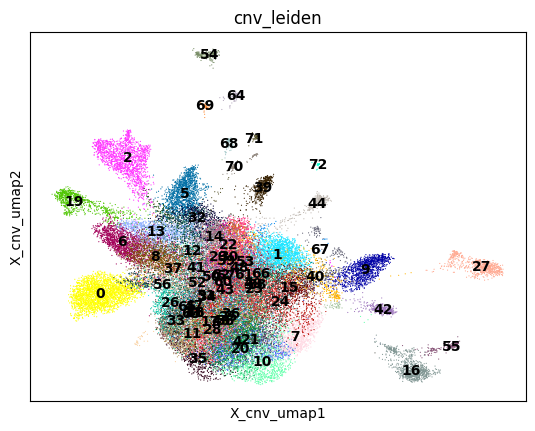

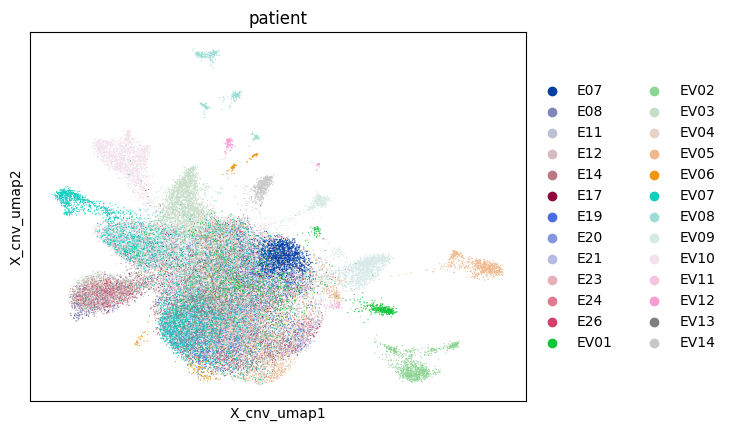

In [26]:
sc.pl.embedding(Q, basis='X_cnv_umap', color=['cnv_leiden'], legend_loc='on data')
sc.pl.embedding(Q, basis='X_cnv_umap', color=['patient'])

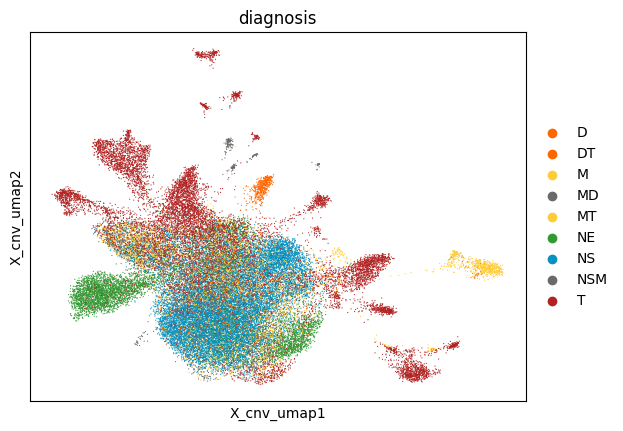

In [27]:
sc.pl.embedding(Q, basis='X_cnv_umap', color=['diagnosis'])

## OVerview

In [28]:
O = Q.obs.copy()
CNV_FIELD = 'cnv_score'
CNV_FIELD = 'ss'

from crukiopy.colormaps import color_dict_diagnosis
color_dict_diagnosis['MT'] = color_dict_diagnosis['T'] 
color_dict_diagnosis['MD'] = color_dict_diagnosis['D'] 
color_dict_diagnosis['MDT'] = color_dict_diagnosis['T'] 
color_dict_diagnosis['DT'] = color_dict_diagnosis['T'] 
cats = sorted(O.query('diagnosis=="NS"').samplename.unique()) + sorted(O.query('diagnosis=="NE"').samplename.unique()) +  sorted(O.query('diagnosis!="NS" and diagnosis!="NE"').samplename.unique())
O.samplename = pd.Categorical(O.samplename, categories=cats)
percentile_ns = np.percentile(O.query('diagnosis=="NS"')[CNV_FIELD],99)
percentile_ne = np.percentile(O.query('diagnosis=="NE"')[CNV_FIELD],99)

In [29]:
diag_rename = {'MT': 'T', 'DT':'T', 'MT':'T', 'MDT': 'T', 'NSM': 'M', 'MD':'D'}

/tmp/ipykernel_150849/678556694.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 10 x 2 in image.
/opt/conda/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ./validation_CNV_scatter.png
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 68 rows containing missing values.
03/31/2025 01:35:37 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
/opt/conda/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_jitter : Removed 81 rows containing missing values.
03/31/2025 01:35:39 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


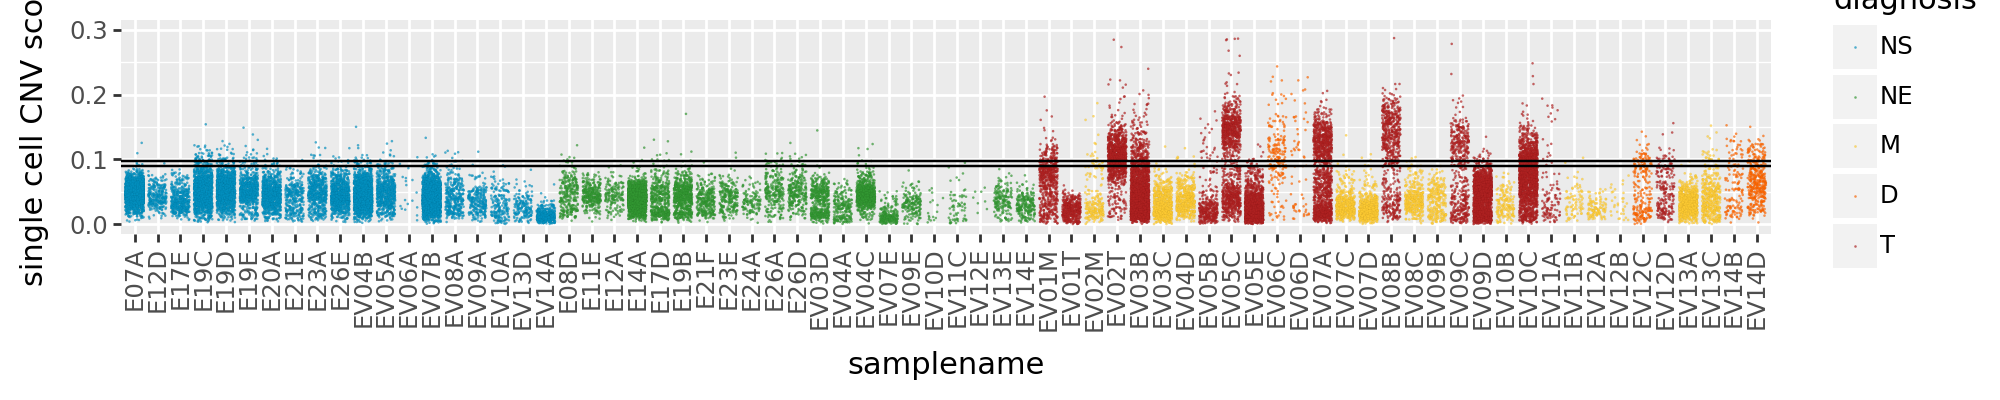

In [30]:
tmp = O.replace({'diagnosis': diag_rename})
tmp2=tmp.diagnosis.astype(str)
tmp.drop('diagnosis', axis=1, inplace=True)
tmp['diagnosis'] = pd.Categorical(tmp2, categories=["NS","NE","M","D","T"])
p = pn.ggplot(tmp, pn.aes('samplename',CNV_FIELD,  fill='diagnosis')) \
+ pn.geom_jitter(size=0.5, alpha=0.7, stroke=0.005, height=0.005) \
+ pn.geom_hline(yintercept=[percentile_ns, percentile_ne]) \
+ pn.theme(figure_size=(10,2), axis_text_x=pn.element_text(rotation=90, hjust=0.5)) + pn.scale_fill_manual(values=color_dict_diagnosis) +  pn.lims(y=[0,0.3]) + pn.labs(y='single cell CNV score')
p.save('./validation_CNV_scatter.png')
p

In [31]:
ed = O.groupby('samplename')[CNV_FIELD].apply(lambda x: np.sum(x > percentile_ne) / x.shape[0] ).apply(lambda x: f"{x:.2f}").to_frame().reset_index()
ed.samplename = ed.samplename.astype(str)
ed.sort_values("samplename").to_csv('/tmp/val_cnv.csv')

/tmp/ipykernel_150849/3277669900.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/tmp/ipykernel_150849/3589168943.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/tmp/ipykernel_150849/3589168943.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

/tmp/ipykernel_150849/3589168943.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to

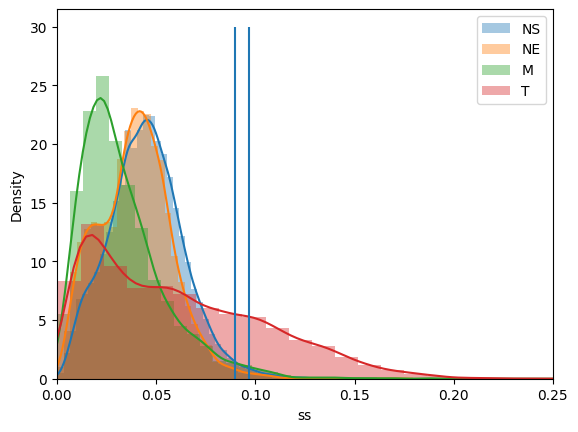

In [32]:
sns.distplot(O.query('diagnosis=="NS"').ss, label='NS')
sns.distplot(O.query('diagnosis=="NE"').ss, label='NE')
sns.distplot(O.query('diagnosis=="M"').ss, label='M')
sns.distplot(O.query('diagnosis=="T"').ss, label='T')
plt.vlines([percentile_ns, percentile_ne], 0, 30)
plt.xlim([0, 0.25])
plt.legend()

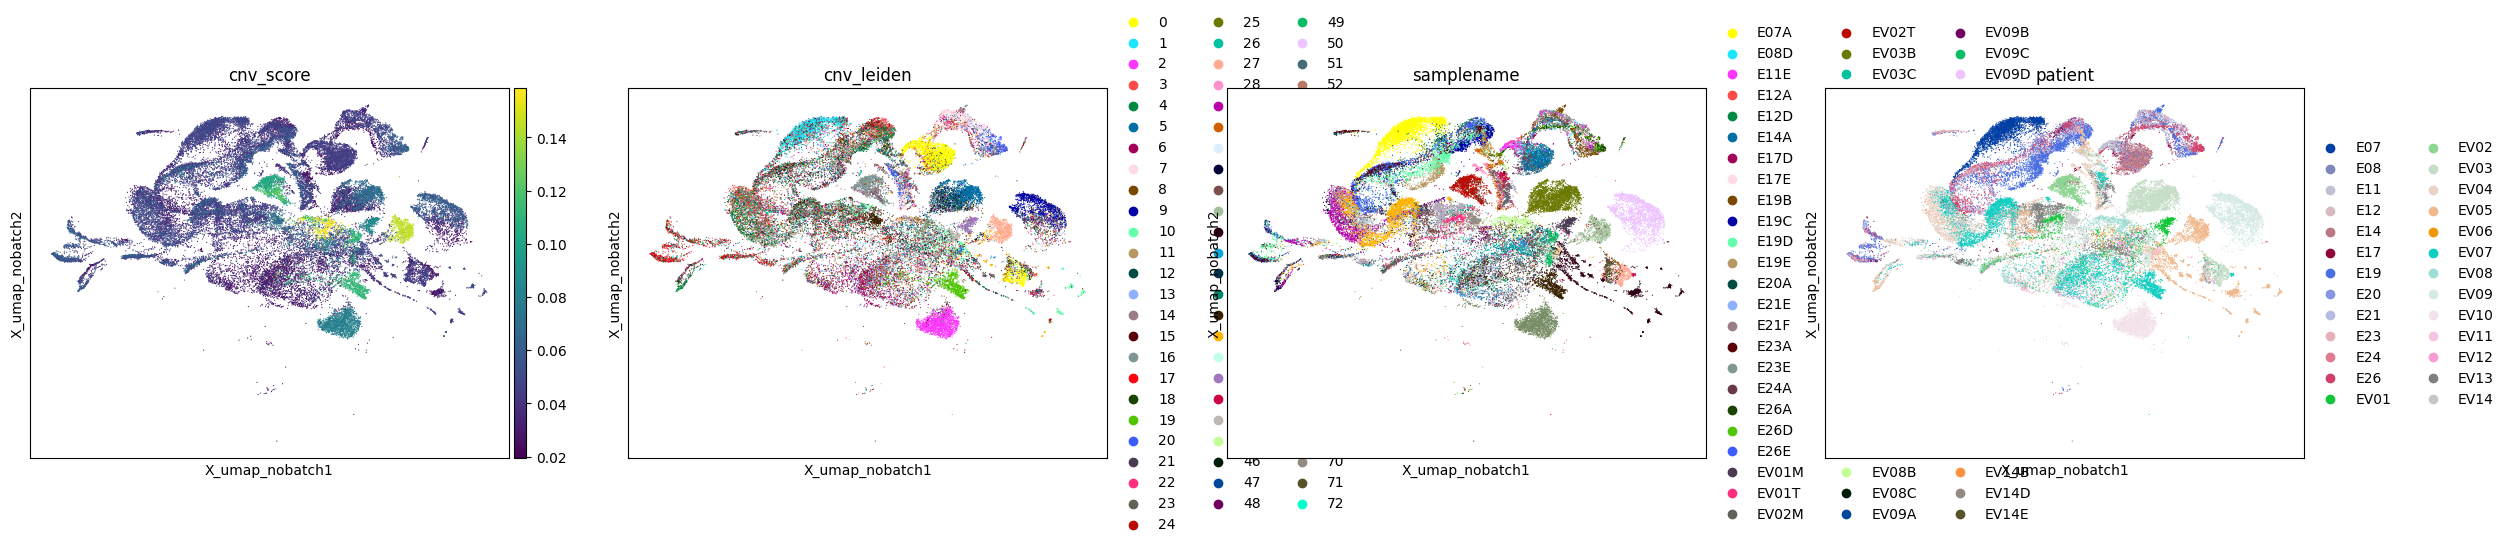

In [33]:
sc.pl.embedding(Q, basis="X_umap_nobatch", color=['cnv_score', 'cnv_leiden', 'samplename', 'patient'])

## Calling CNV cells

### Using the NE/NS reference quantily

In [34]:
Q.obs['cnv_score_per_cell'] = Q.obs['ss']
Q.obs['has_cnv'] = (Q.obs.cnv_score_per_cell > percentile_ns).astype(int)

### Using the purity of CNV clusters (in terms of patient)

In [35]:
Q.obs.patient = Q.obs.patient.astype(str)

In [36]:
cluster_purity = {}
for cnv_leiden, df in Q.obs.groupby('cnv_leiden'):
    freqs = df.patient.value_counts().values
    purity = freqs[0]/freqs.sum()
    cluster_purity[cnv_leiden] = purity

/tmp/ipykernel_150849/2605962763.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


/tmp/ipykernel_150849/3451041889.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: ylabel='Density'>

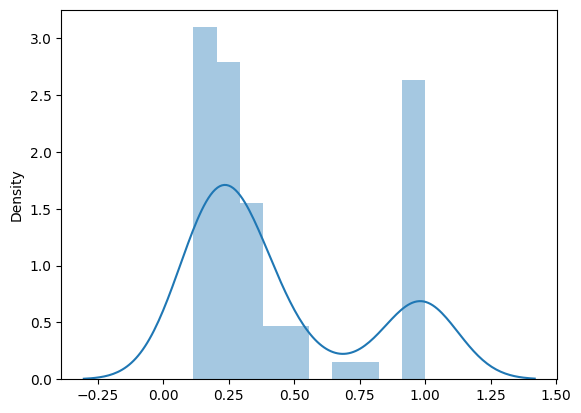

In [37]:
sns.distplot(list(cluster_purity.values()), bins=10)

In [38]:
Q.obs['cnv_purity'] = Q.obs.cnv_leiden.apply(lambda x: cluster_purity[x])
Q.obs['has_cnv_purity'] = (Q.obs['cnv_purity'] > 0.75).astype(int)

... storing 'patient' as categorical


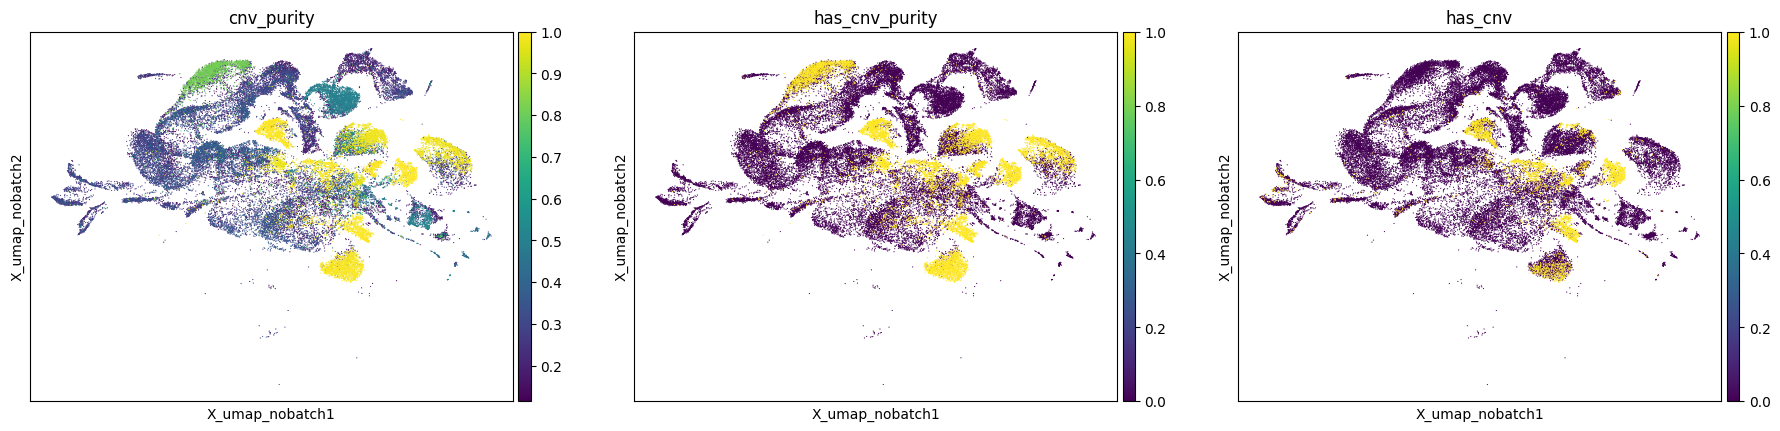

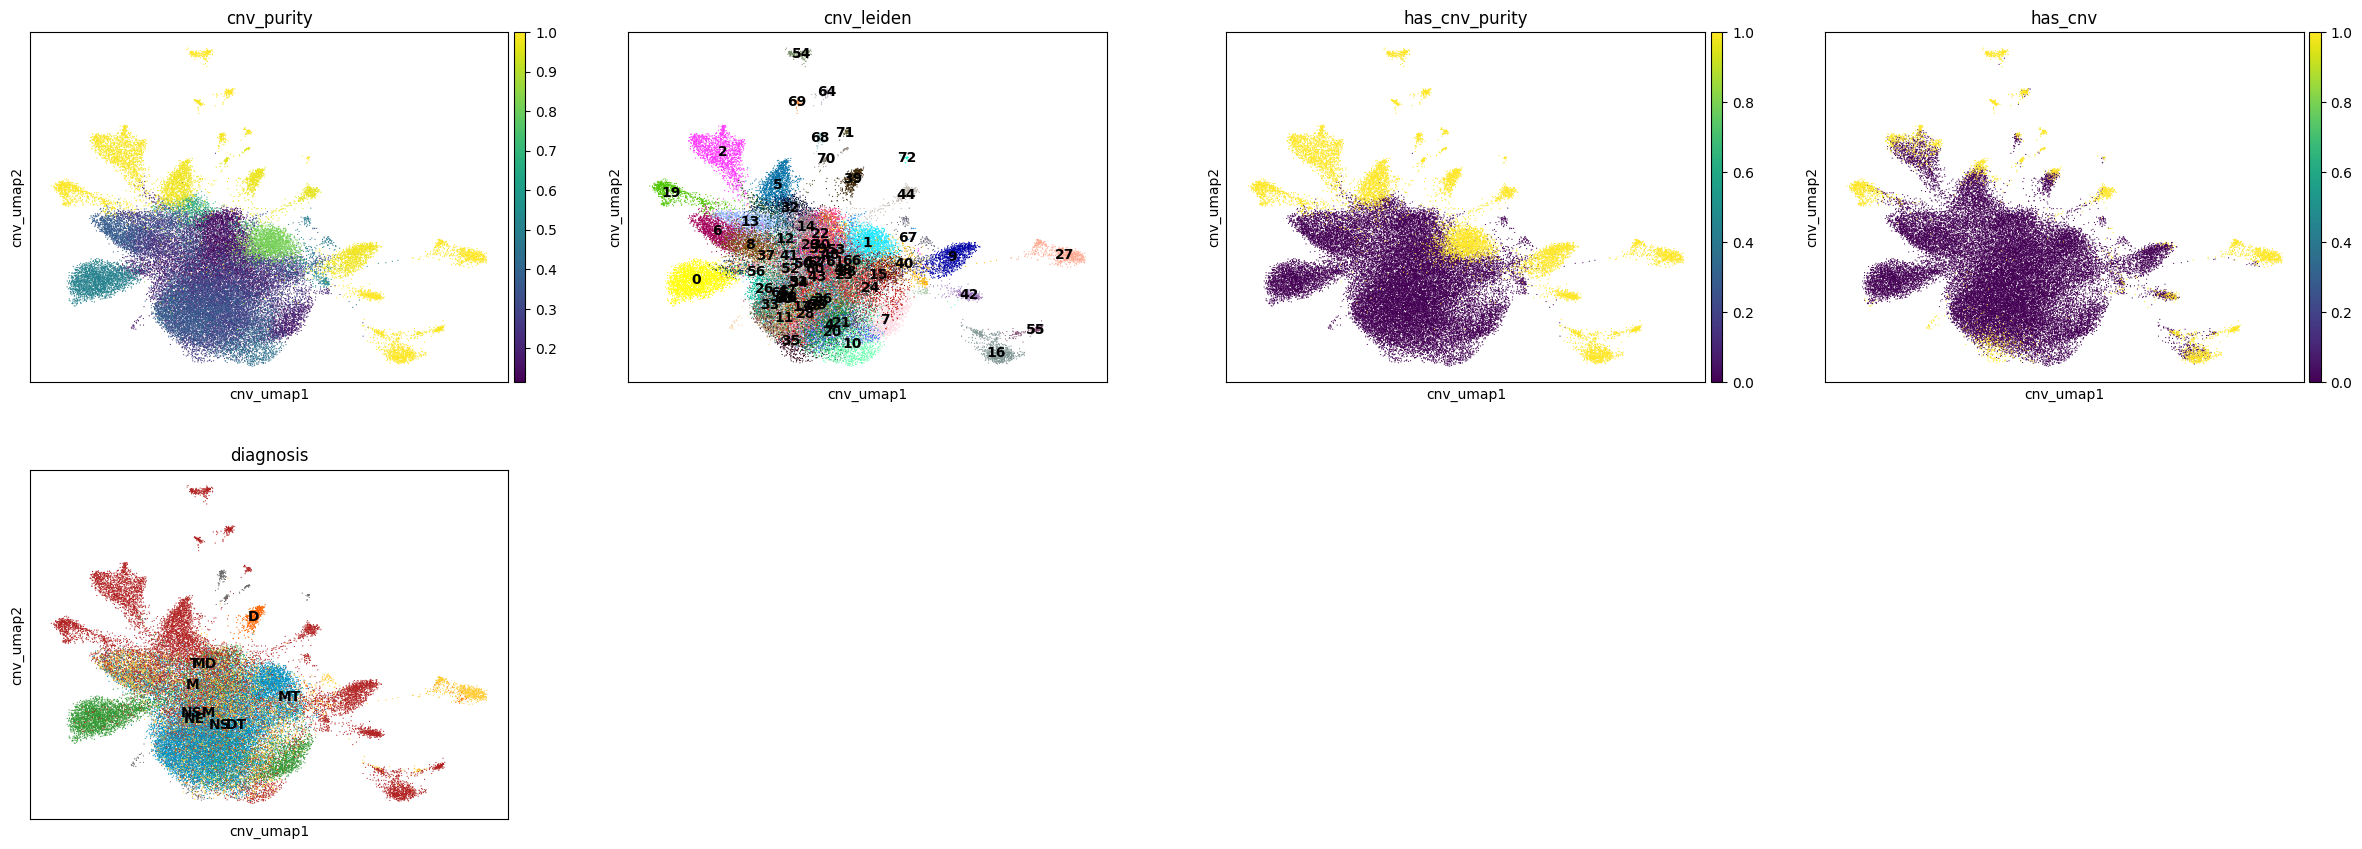

In [39]:
sc.pl.embedding(Q, basis='X_umap_nobatch', color=['cnv_purity', 'has_cnv_purity', 'has_cnv'])
cnv.pl.umap(Q, color=['cnv_purity', 'cnv_leiden', 'has_cnv_purity', 'has_cnv', 'diagnosis'], legend_loc='on data')

# Clonal relations

In [40]:
from flowcharts import *

## EV01

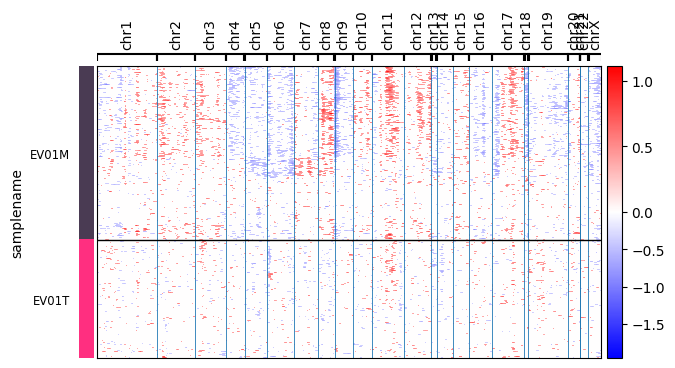

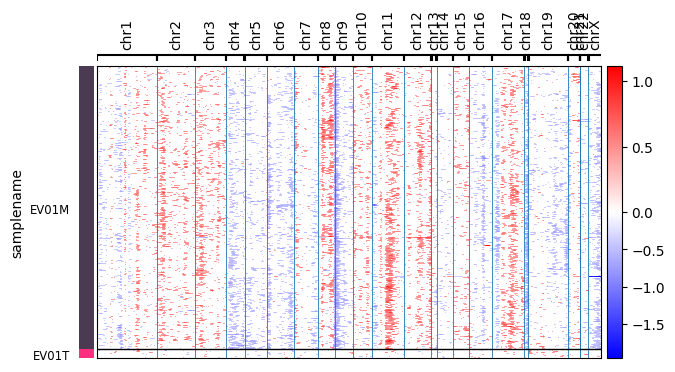

In [42]:
patient = "EV01"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV02

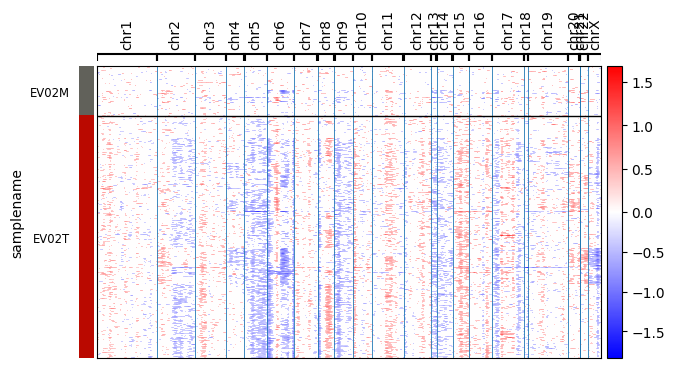

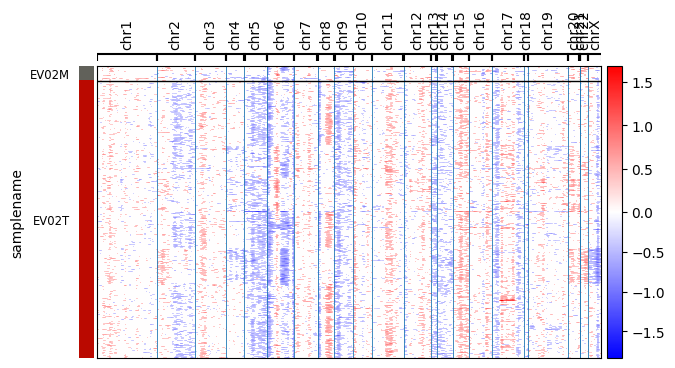

In [43]:
patient = "EV02"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV03

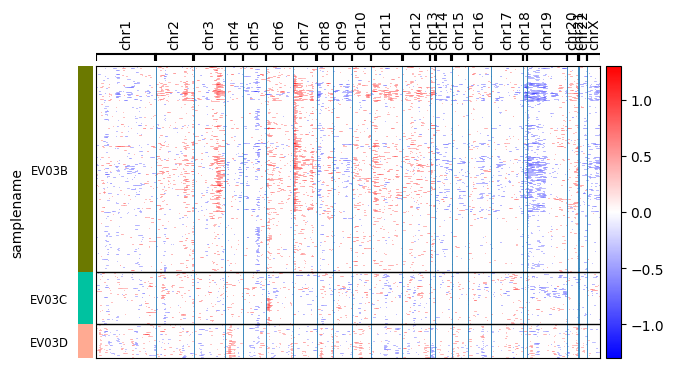

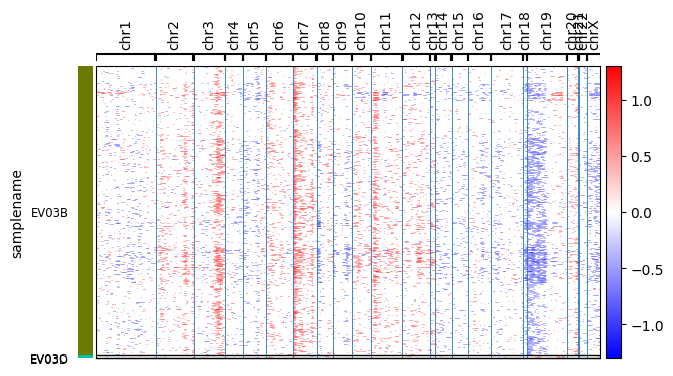

In [44]:
patient = "EV03"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV04

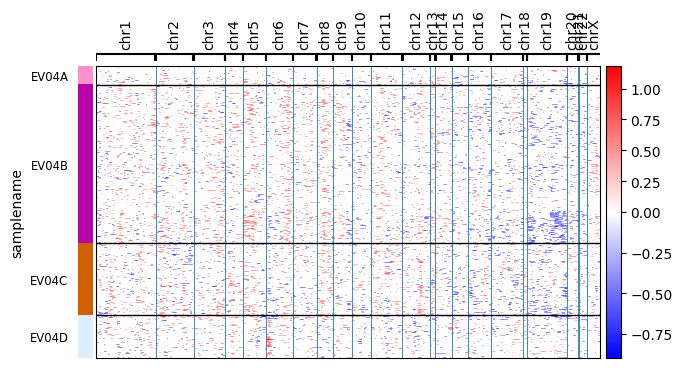

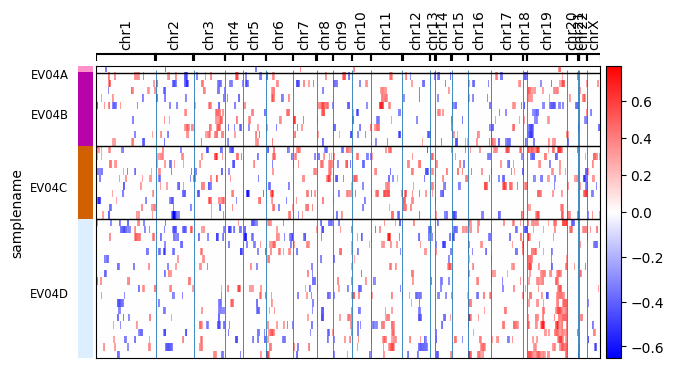

In [45]:
patient = "EV04"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV05

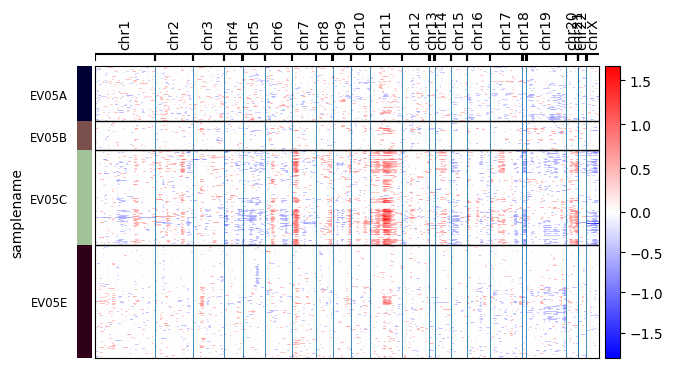

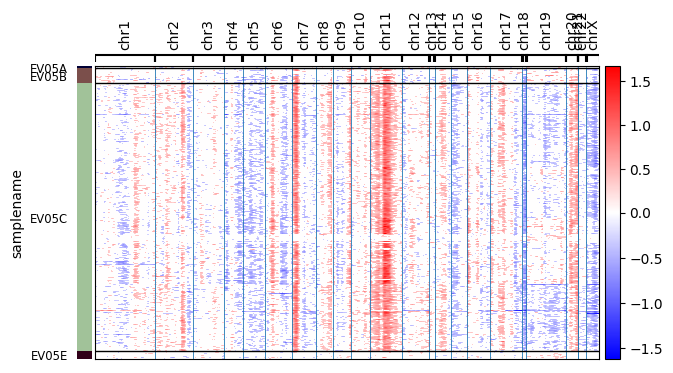

In [46]:
patient = "EV05"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV06

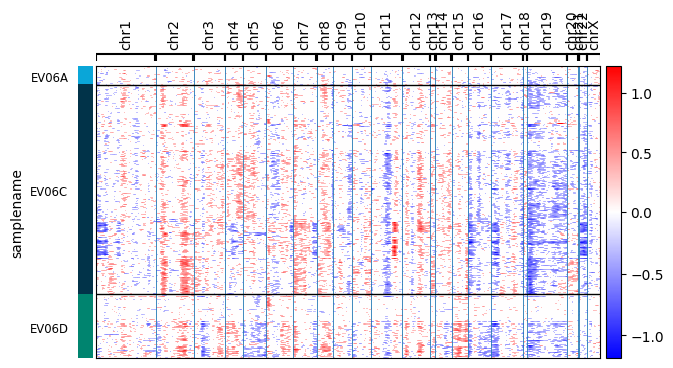

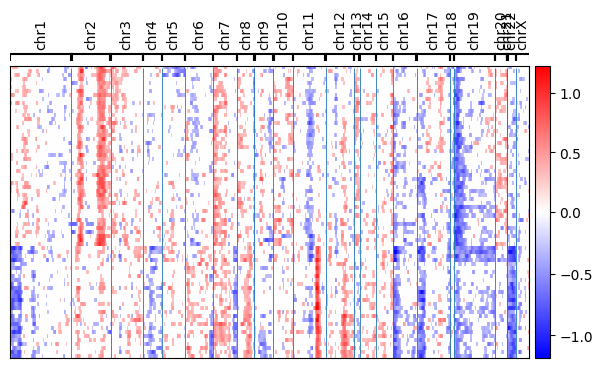

In [47]:
patient = "EV06"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV07

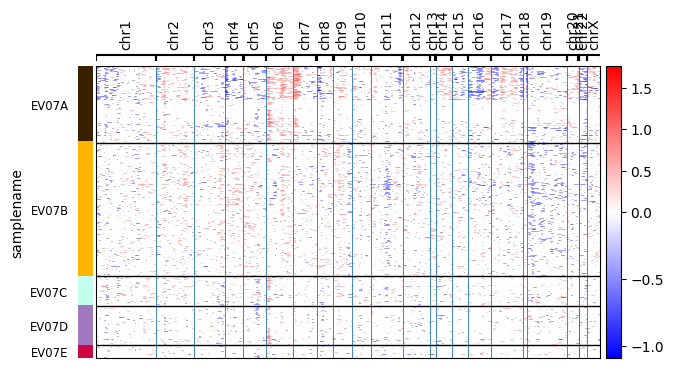

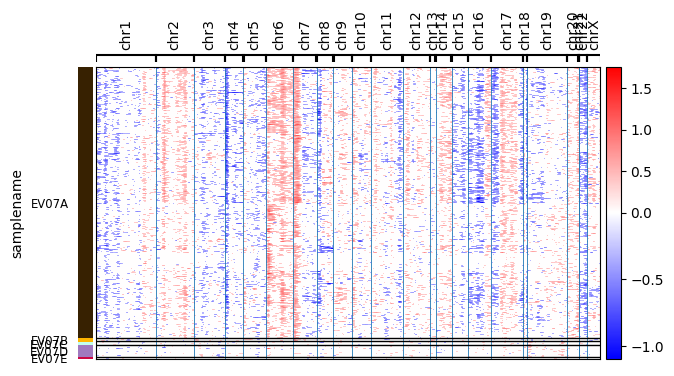

In [48]:
patient = "EV07"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV08

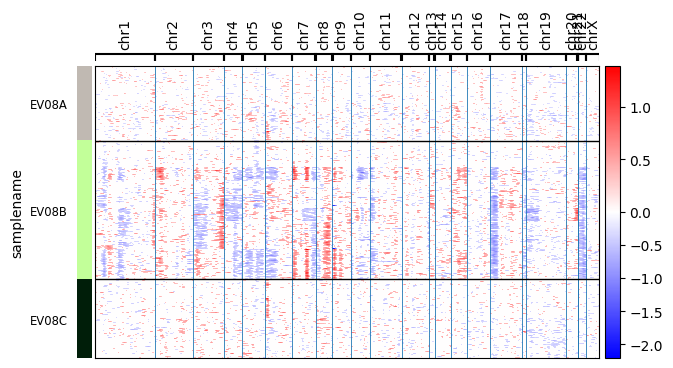

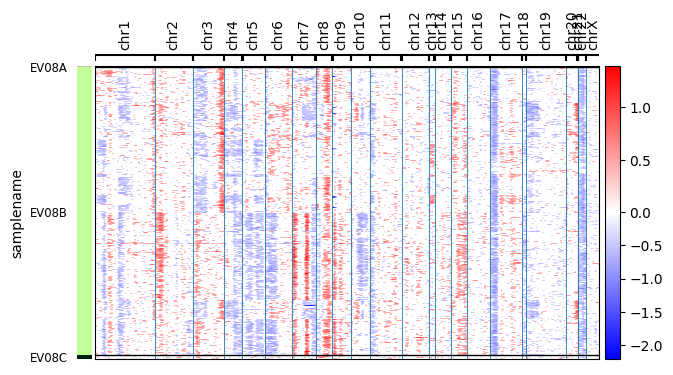

In [49]:
patient = "EV08"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV09
E33F is a metastasis!

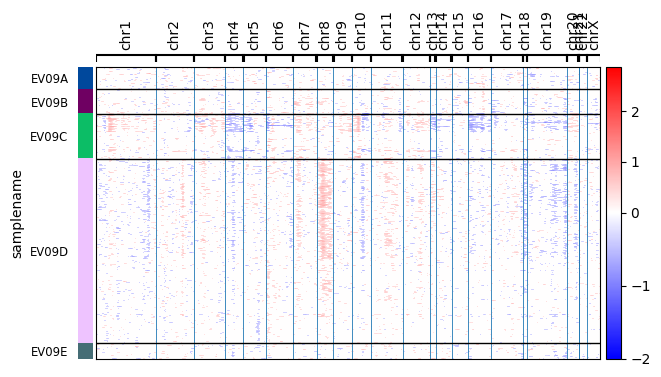

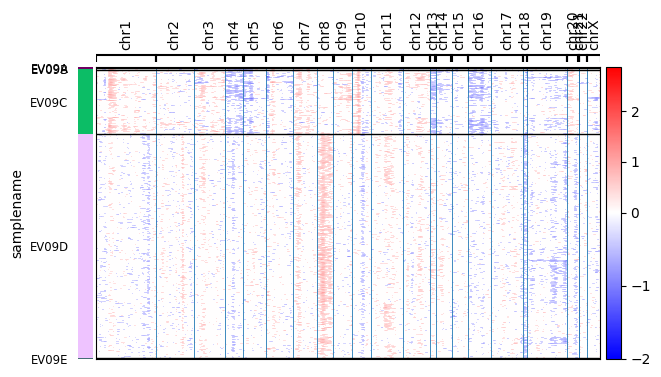

In [50]:
patient = "EV09"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV10

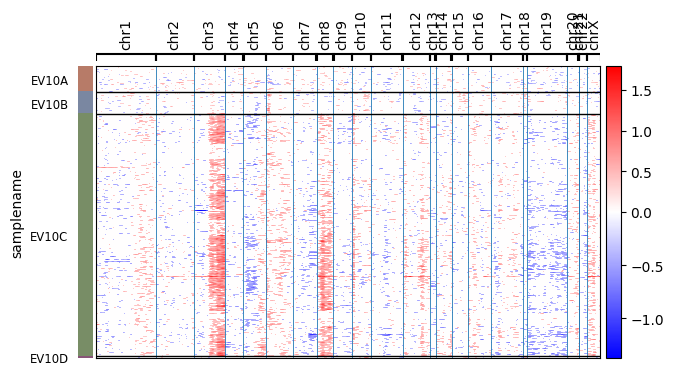

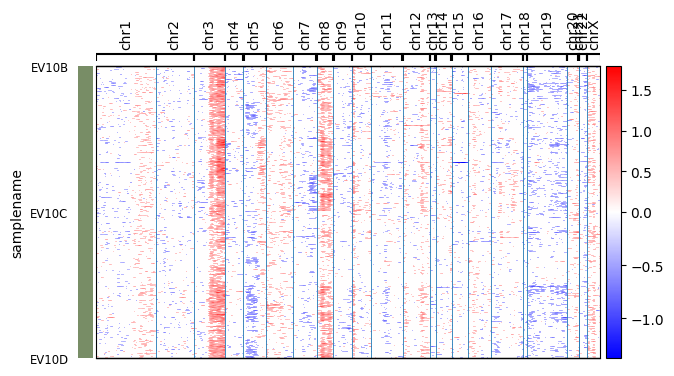

In [51]:
patient = "EV10"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV11

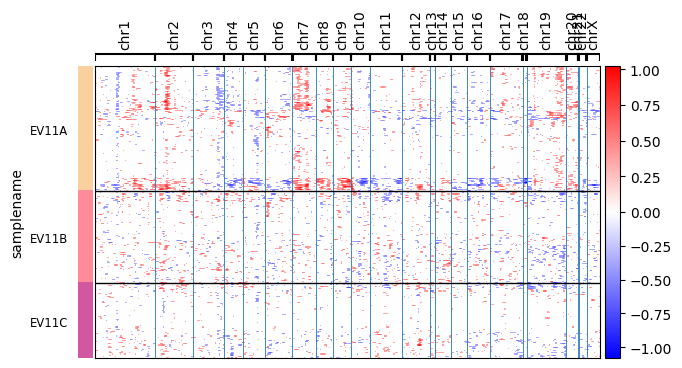

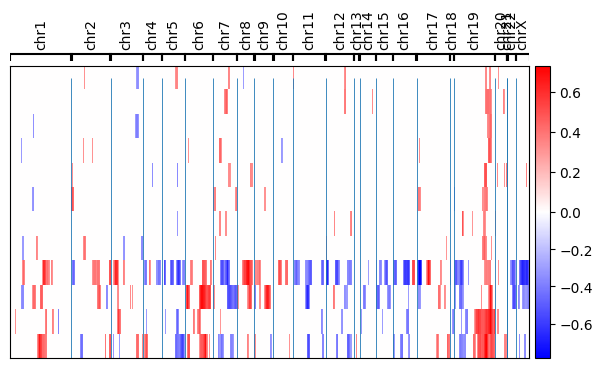

In [52]:
patient = "EV11"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV12

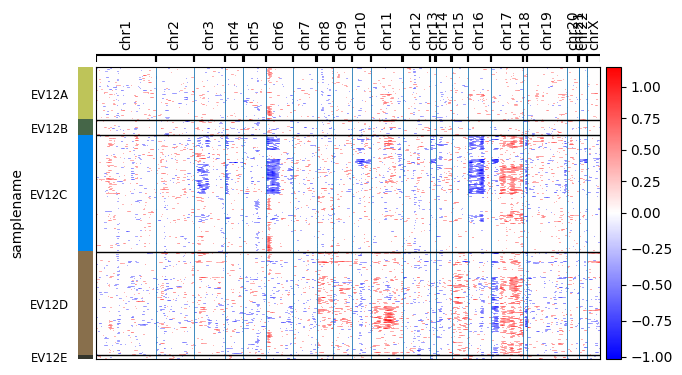

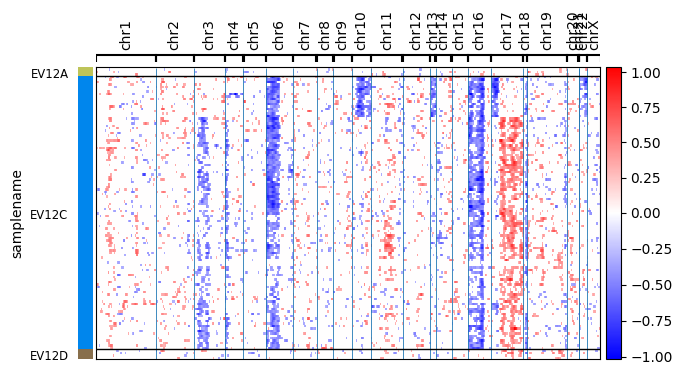

In [53]:
patient = "EV12"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV13

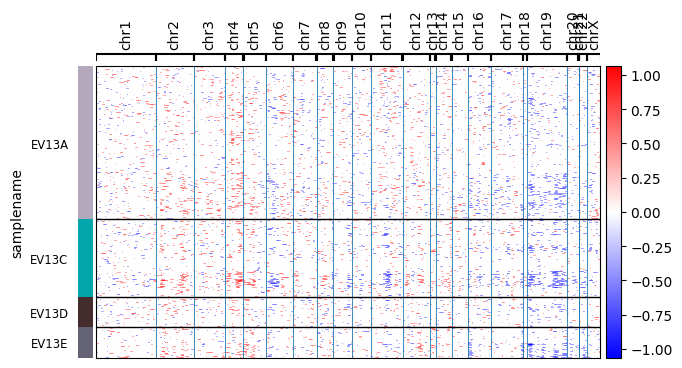

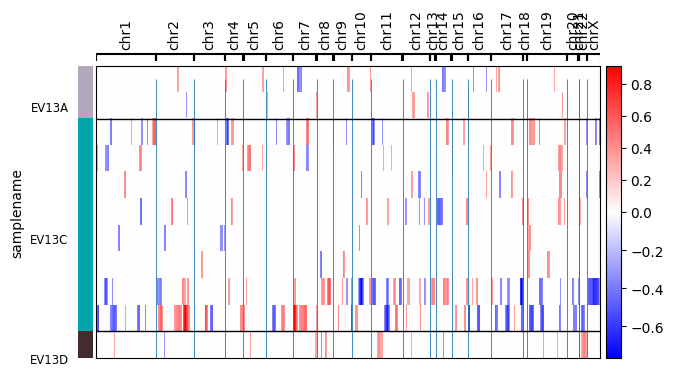

In [54]:
patient = "EV13"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

## EV14

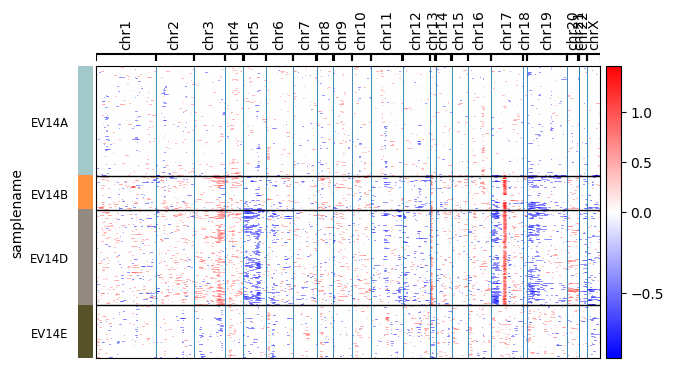

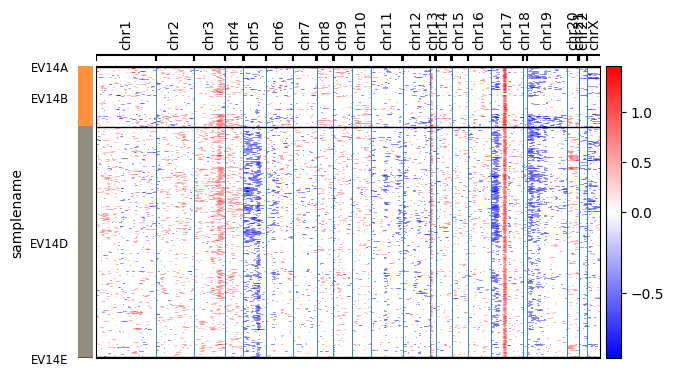

In [55]:
patient = "EV14"
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient').index], figsize=(7,4), groupby='samplename', do_subclustering=True)
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient in @patient and has_cnv_purity==1').index], figsize=(7,4), groupby='samplename', do_subclustering=True)

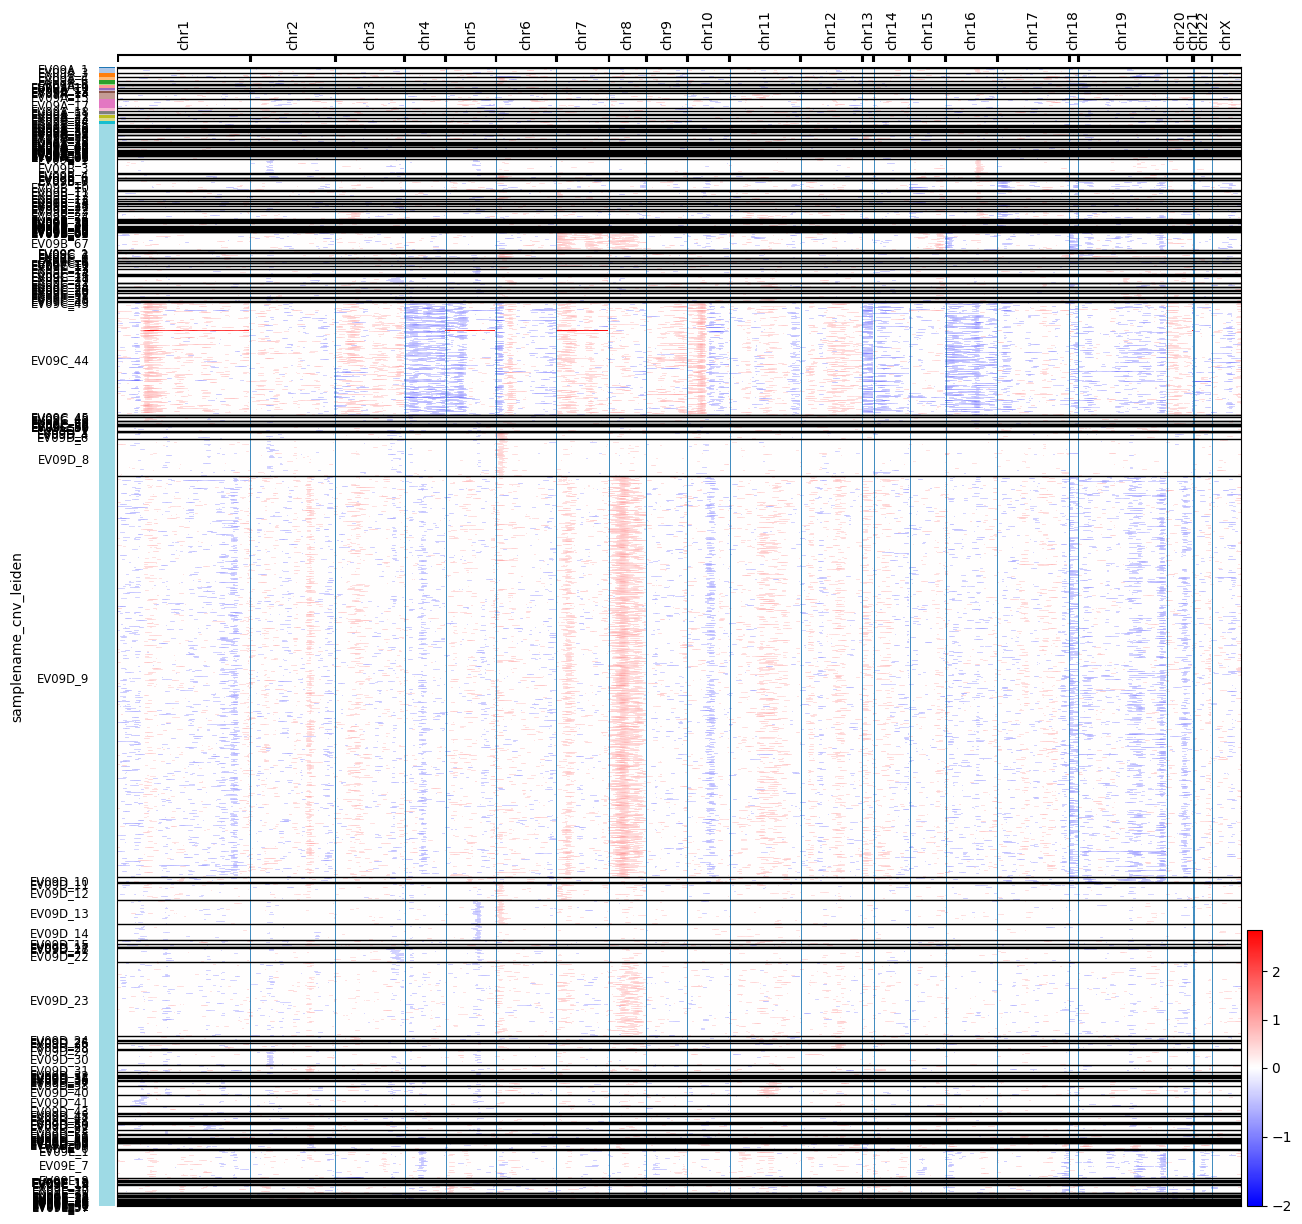

In [56]:
cnv.pl.chromosome_heatmap(Q[Q.obs.query('patient == "EV09"').index], figsize=(15,15), groupby=['samplename', 'cnv_leiden'])

In [57]:
Q.obs[['cnv_ref','cnv_leiden','cnv_score', 'ss']]

cnv_ref cnv_leiden  cnv_score        ss
AAACCCAAGTTTCAGC-E12A   reference_NE          0   0.044033  0.070666
AAACGAAAGTAGGATT-E12A   reference_NE         35   0.082745  0.085274
AAAGTCCTCGGAGATG-E12A   reference_NE          0   0.044033  0.073389
AAAGTGAGTTGAATCC-E12A   reference_NE          0   0.044033  0.035887
AACAAGATCCGAACGC-E12A   reference_NE         66   0.036740  0.031990
...                              ...        ...        ...       ...
TTTAGTCGTAGGTCAG-EV05B         query         38   0.031619  0.011978
TTTCACAGTTATGGTC-EV05B         query         27   0.145941  0.075765
TTTCCTCGTACCCGAC-EV05B         query         38   0.031619  0.052921
TTTCGATGTATACGGG-EV05B         query         40   0.054627  0.056616
TTTGGTTCAAGATTGA-EV05B         query         21   0.048142  0.012896

[43644 rows x 4 columns]

# Save CNV data to disk

In [56]:
Q.obs[
    ['cnv_ref','cnv_leiden','cnv_score', 'ss','cnv_score_per_cell','has_cnv','cnv_purity', 'has_cnv_purity']
].to_csv('/proj/huang/tmp/atlas_validation_cnv_annotation.csv')

# Plots for paper

In [78]:
adata_validation = load_validation_data()
df_cnv = pd.read_csv('/proj/huang/tmp/atlas_validation_cnv_annotation.csv', index_col=0)
adata_validation.obs= adata_validation.obs.merge(df_cnv[['has_cnv', 'cnv_score']], left_index=True, right_index=True, how='left')
adata_validation.obs['has_cnv2'] = adata_validation.obs.cnv_score.map(lambda x: 'yes' if x > percentile_ns else 'no')

In [79]:
# df_gg = adata_validation.obs.replace({'has_cnv': {np.nan: 'unknown', 1.0 :'yes', 0.0:'no'}})

03/31/2025 01:43:52 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


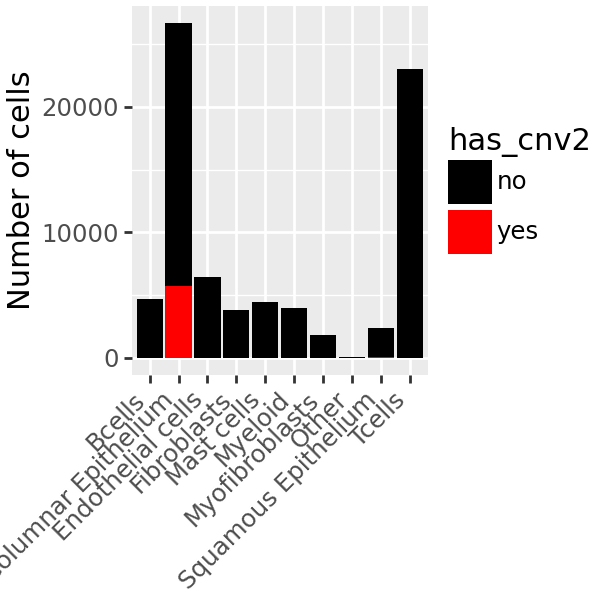

In [80]:
p = (
    pn.ggplot(df_gg, pn.aes('celltype_split', fill='has_cnv2')) 
    + pn.geom_bar()
    + pn.theme(figure_size=(3,3), axis_text_x=pn.element_text(rotation=45, hjust=1))
    + pn.scale_fill_manual({'yes': 'red', 'no': 'black', 'unknown' :'lightgrey'})
    + pn.labs(x='', y='Number of cells')
)
p

In [81]:
_tmp = df_gg.replace({'diagnosis': diag_rename})
_tmp.diagnosis = pd.Categorical(_tmp.diagnosis, ['NE','M','D','T','NS'])

/tmp/ipykernel_150849/2349681116.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


03/31/2025 01:43:56 PM Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


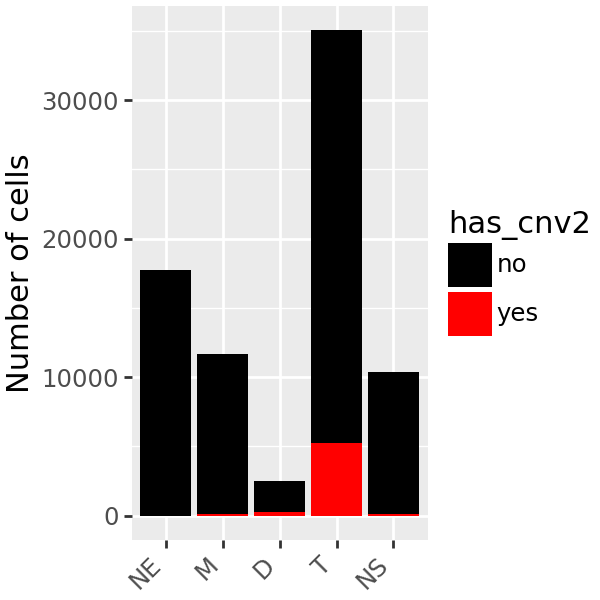

In [82]:
p = (
    pn.ggplot(_tmp)
    + pn.aes('diagnosis', fill='has_cnv2')
    + pn.geom_bar()
    + pn.theme(figure_size=(3,3), axis_text_x=pn.element_text(rotation=45, hjust=1)) 
    # + pn.scale_fill_manual(['lightgrey', 'black', 'red']) 
    + pn.scale_fill_manual({'yes': 'red', 'no': 'black', 'unknown' :'lightgrey'})

    + pn.labs(x='', y='Number of cells') 
)
p